# Import and preprocces data

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize as minimize

In [166]:
teams = ["AiCU", "Croperators", "DeepGreens", "iGrow", "Reference(Growers)","Sonoma"]
data = {}
for team in teams:
    GHClim = pd.read_csv(f"data/{team}/Greenhouse_climate.csv") 
    Crop = pd.read_csv(f"data/{team}/CropManagement.csv") 
    irri = pd.read_csv(f"data/{team}/Irrigation.csv") 
    prod = pd.read_csv(f"data/{team}/Production.csv") 
    vip = pd.read_csv(f"data/{team}/vip.csv") 
    GHClim = GHClim.drop(['VentLee', 'Ventwind', 'AssimLight', 'BlackScr', 'EnScr'], axis=1)
    
    GHClim.fillna(method='ffill', inplace=True)
    Crop.fillna(method='ffill', inplace=True)
    irri.fillna(method='ffill', inplace=True)
    prod.fillna(method='ffill', inplace=True)
    vip.fillna(method='ffill', inplace=True)
    
    # If the last column is NaN
    GHClim.fillna(method='ffill', inplace=True)
    Crop.fillna(method='ffill', inplace=True)
    irri.fillna(method='ffill', inplace=True)
    prod.fillna(method='ffill', inplace=True)
    vip.fillna(method='ffill', inplace=True)
    data[team] = {'GHClim':GHClim, 'Crop':Crop, 'irri':irri, 'prod':prod, 'vip':vip}

In [167]:
data[teams[4]]['GHClim']

,CO2air,GHtime,HumDef,PipeGrow,PipeLow,RHair,Tair
0,NaN,43326.000000,NaN,NaN,NaN,NaN,NaN
1,NaN,43326.003472,NaN,NaN,NaN,NaN,NaN
2,484.000000,43326.006944,2.76,0.0,0.0,84.2,20.2
3,479.000000,43326.010417,2.64,0.0,0.0,84.6,19.9
4,482.000000,43326.013889,2.60,0.0,0.0,84.8,19.9
...,...,...,...,...,...,...,...
33128,654.999994,43441.027778,3.81,0.0,37.0,81.3,22.9
33129,738.000000,43441.031250,3.86,0.0,37.0,81.4,23.2
33130,896.000005,43441.034722,3.99,0.0,35.9,81.0,23.4
33131,966.999990,43441.038194,4.12,0.0,35.3,80.6,23.6


# Weekly average

Like mentioned the GHtime is the timestamp per 5 minutes. Every time it changes with +- 0.0034722, this is $\frac{1}{1440}$ of a day: 5 minutes. So the GHtime is in days. One week is 7 days, so if we would like to take the average of every week, we would need to take the average of time the GHtime, changed by 7. 1 week is 10080 minutes. So 1 week is $\frac{10080}{5}$ timestamps, is 2016 timestamps.

In [168]:
run = 'Maybe'
while run != 'Yes' and run != 'No':
    print('Please type Yes or No (case sensitive)')    
    run = str(input('Would you like to divide the data in weekly data? [Yes/No]'))

if run == 'Yes':
    # Create a dictionary with weekly data to create more usuable data
    weekly_data_per_team = dict()
    for team in teams:
        # Add important features from greenhouse climate dataset
        weekly_CO2, weekly_HumDef = [], []
        for i in range(len(data[team]['GHClim']['GHtime'])//2016):
            weekly_HumDef.append(data[team]['GHClim']['HumDef'][i*2016:i*2016+2016].mean())
            weekly_CO2.append(data[team]['GHClim']['CO2air'][i*2016:i*2016+2016].mean())

        # Add weekly production value (fruit number multiplied by price) 
        weekly_prodA, weekly_prodB = [], []
        # Timestamp is per day 
        for i in range(len(data[team]['prod']['time'])//7):
            weekly_prodA.append(np.mean(data[team]['prod']['ProdA_num'][i*7:i*7+7]))
            weekly_prodB.append(np.mean(data[team]['prod']['ProdB_num'][i*7:i*7+7]))
        weekly_data_per_team[f'{team}'] = {'CO2air':weekly_CO2, 'HumDef':weekly_HumDef, 
                                'prodA':weekly_prodA, 'prodB':weekly_prodB}
    print("""The code is succesfully runned and the weekly data 
          devided by team is now in the variable 'weekly_data_per_team'""")

Please type Yes or No (case sensitive)
Would you like to divide the data in weekly data? [Yes/No]Yes
The code is succesfully runned and the weekly data 
          devided by team is now in the variable 'weekly_data_per_team'


In [169]:
if run == 'Yes':
    # Create a dictionary with weekly data to create more usuable data
    weekly_CO2, weekly_HumDef = [], []
    weekly_prodA, weekly_prodB = [], []
    for team in teams:
        # Add important features from greenhouse climate dataset

        for i in range(len(data[team]['GHClim']['GHtime'])//2016):
            weekly_HumDef.append(data[team]['GHClim']['HumDef'][i*2016:i*2016+2016].mean())
            weekly_CO2.append(data[team]['GHClim']['CO2air'][i*2016:i*2016+2016].mean())

        # Add weekly production value (fruit number multiplied by price) 

        # Timestamp is per day 
        for i in range(len(data[team]['prod']['time'])//7):
            weekly_prodA.append(np.mean(data[team]['prod']['ProdA_num'][i*7:i*7+7]))
            weekly_prodB.append(np.mean(data[team]['prod']['ProdB_num'][i*7:i*7+7]))
    weekly_data_total = {'CO2':weekly_CO2, 'HumDef':weekly_HumDef, 
                  'prodA':weekly_prodA, 'prodB':weekly_prodB}
    print("""The code is succesfully runned and the weekly data not
          devided by team is now in the variable 'weekly_data_total'""")
else:
    # Take the average of the features and the eventual production value of every team
    tair, hum_def, prod = [], [], []
    category = 'ProdA_cum'
    for team in teams:
#         for category in ['ProdA_cum', 'ProdB_cum']:
        prod_df = data[team]['prod'][category]
        tair.append(data[team]['GHClim']['Tair'].mean())
        hum_def.append(data[team]['GHClim']['HumDef'].mean())
        prod.append(prod_df[prod_df.index[-1]])
        plt.plot(hum_def, prod, '.', label=f'{team}:HumDef')   

The code is succesfully runned and the weekly data not
          devided by team is now in the variable 'weekly_data_total'


# Polynomial fitting
## On weekly data

Which degree of polynomial fitting would you like?2


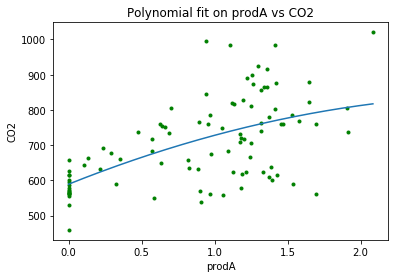

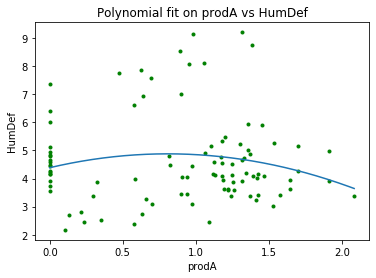

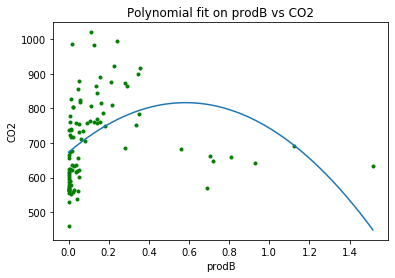

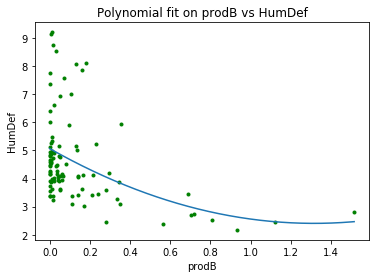

In [170]:
def polynome(params, linspace):
    if len(params)==3:
        a,b,c = params
        return [a*i**2+b*i+c for i in linspace]
    if len(params)==4:
        a,b,c,d = params
        return [a*i**3+b*i**2+c*i+d for i in linspace]
    if len(params)==5:
        a,b,c,d,e = params
        return [a*i**4+b*i**3+c*i**2+d*i+e for i in linspace]
    if len(params)==6:
        a,b,c,d,e,f = params
        return [a*i**5+b*i**4+c*i**3+d*i**2+e*i+f for i in linspace]
    if len(params)==7:
        a,b,c,d,e,f,g = params
        return [a*i**6+b*i**5+c*i**4+d*i**3+e*i**2+f*i+g for i in linspace]


# Ask for input
degree = 0
while not 2<=degree<=6:
    try:
        degree = int(input('Which degree of polynomial fitting would you like?'))
        if not 2<=degree<=6:
            print('Please chose an integer between 2 and 6')
    except ValueError:
        print('Please chose an integer between 2 and 6.')
if run == 'Yes':
    for x_name in ['prodA', 'prodB']:
        for y_name in ['CO2', 'HumDef']:
            x, y = weekly_data_total[x_name], weekly_data_total[y_name]
            plt.plot(x, y, '.g')
            params = np.polyfit(x,y, degree)
            plt.plot(np.linspace(min(x),max(x),1000), polynome(params, np.linspace(min(x),max(x),1000)))
            plt.xlabel(x_name)
            plt.ylabel(y_name)
            plt.title(f'Polynomial fit on {x_name} vs {y_name}')
            plt.show()
else:
    
#     plt.plot(tair, prod, '.', label=f'{team}Tair')
    plt.ylabel("Production")
    plt.xlabel("Features")
    plt.legend()
    plt.show()